In [1]:
import json
import os
import typing
import contextlib
import zipfile
from pathlib import Path
from types import SimpleNamespace

# Available: https://github.com/kaggle/docker-python
import jax
from flax import nnx
import attrs
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import kagglehub
import IPython
from kauldron import kd

ipython = IPython.get_ipython()
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

In [2]:
def detect_run_env() -> typing.Literal["interactive", "batch", "local", "unknown"]:
    if not Path("/kaggle").exists():
        return "local"

    run_type = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "").strip().lower()
    if run_type in {"interactive","batch"}:
        return run_type
    raise KeyError(f"Unknown kaggle run type {run_type!r}")

run_env = detect_run_env()
print(run_env)


local


In [4]:
if run_env != "local":
    ipython.magic('pip install "git+https://github.com/google-deepmind/gemma.git@v3.1.0" "etils[etree]>=1.13"')

In [5]:
match run_env:
    case "local":
        proj_root = Path("..").resolve()
        data_dir = proj_root/"data"
        inputs = data_dir/"arc-prize-2025.zip"
    case _:
        inputs = Path("/kaggle/input/arc-prize-2025/")

@contextlib.contextmanager
def load_file(root, relative, mode="r"):
    match root.suffix:
        case ".zip":
            with zipfile.ZipFile(root, "r") as zfh:
                fh = zfh.open(relative)
                yield fh
        case "":
            with open(root/relative, mode) as fh:
                yield fh
        case _:
            raise KeyError(f"Uknown suffix {root.suffix!r}")
        

In [6]:
def parse_inputs(v,had_list=False):
    match v:
        case dict():
            return SimpleNamespace(**{kk:parse_inputs(vv) for kk,vv in v.items()})
        case list():
            if not had_list:
                return tuple(parse_inputs(vv,True) for vv in v)
            else:
                return np.array(v,dtype="i1")
        case _:
            raise TypeError(f"Unsupported type {type(v).__name__}")


In [7]:
with load_file(inputs, "arc-agi_training_challenges.json", "rt") as fh:
    train_inputs = {k:parse_inputs(v) for k,v in json.load(fh).items()}
with load_file(inputs, "arc-agi_training_solutions.json", "rt") as fh:
    train_outputs = {k:parse_inputs(v) for k,v in json.load(fh).items()}

In [8]:
train_pairs = {}
for k,v in train_inputs.items():
    train_pairs[k] = SimpleNamespace(
        train = v.train,
        test = tuple(SimpleNamespace(
            input = i.input,
            output = o,
        ) for i,o in zip(v.test, train_outputs[k])),
    )
print(len(train_pairs))

1000


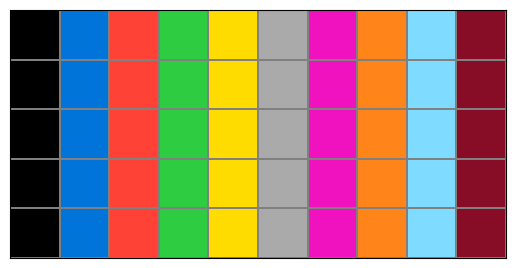

In [2]:
# ARC color map - colors for values 0-9
cmap = mpl.colors.ListedColormap([
    "#000000", "#0074D9", "#FF4136", "#2ECC40", "#FFDC00",
    "#AAAAAA", "#F012BE", "#FF851B", "#7FDBFF", "#870C25",
])
norm = mpl.colors.Normalize(vmin=0, vmax=9)

def show_arc_image(img, *, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.pcolormesh(
        img,
        cmap=cmap, norm=norm,
        ec="gray",lw=0.1,
    )
    ax.yaxis.set_inverted(True)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("equal","box")

show_arc_image(np.r_[:10]+0*np.r_[:5][:,None])
#show_arc_image(train_pairs["18419cfa"].train[0].input)

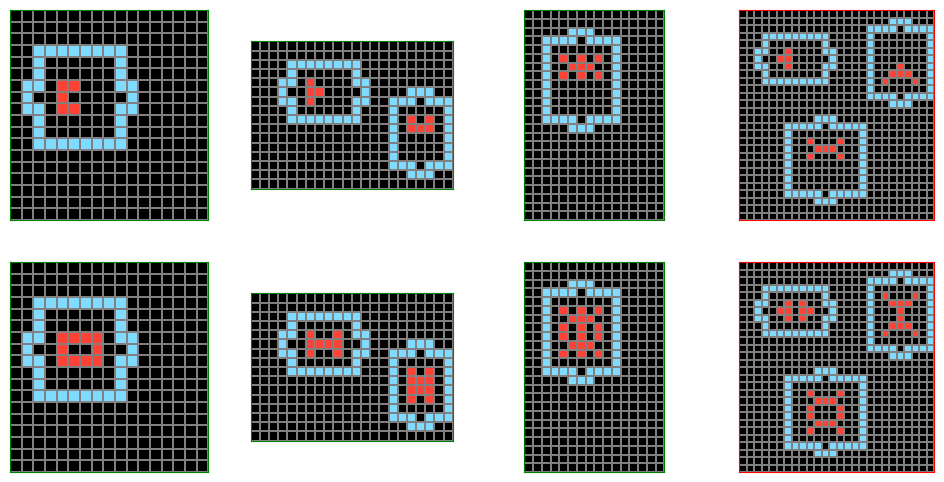

In [10]:
def show_arc_test_case(test_case):
    pairs = test_case.train + test_case.test
    N = len(pairs)
    fig, axes = plt.subplots(2,N,figsize=(12,2*12/N))
    for i,(p,axe) in enumerate(zip(pairs, axes.T)):
        c = "green" if i<len(test_case.train) else "red"
        for k,ax in zip(["input","output"],axe):
            v = getattr(p,k,None)
            if v is None:
                continue
            show_arc_image(v, ax=ax)
            for spine in ax.spines.values():
                spine.set_edgecolor(c)

show_arc_test_case(train_pairs["18419cfa"])

In [11]:
gemma_variant = "v3-270m-it".split("-")

gemma_src_name = {
    "v3-270m": "gemma-3-270m",
    "v3-1b": "gemma3-1b",
    "v3-4b": "gemma3-4b",
}["-".join(gemma_variant[:2])] + {
    "it": "-it"
}[gemma_variant[2]]

gemma_src_version = 1

if run_env == "local":
        # Download latest version
    gemma_dir = Path(kagglehub.model_download(f"google/gemma-3/flax/{gemma_src_name}"))
    
    print("Path to model files:", gemma_dir)
else:
    gemma_dir = Path(f"/kaggle/input/gemma-3/flax/{gemma_src_name}/{gemma_src_version}")


Path to model files: /Users/yves/.cache/kagglehub/models/google/gemma-3/flax/gemma-3-270m-it/1


In [ ]:
from gemma import gm

if gemma_variant[1] == "270m" and not hasattr(gm.nn,"Gemma3_270M"):
    from gemma.gm.nn import _transformer, _config
    
    _NUM_LAYERS_GEMMA3_270M = 18
    
    class Gemma3_270M(_transformer.Transformer):  # pylint: disable=invalid-name
        """Gemma3 transformer architecture."""
    
        config: _config.TransformerConfig = _config.TransformerConfig(
            final_logit_softcap=None,
            num_embed=262144,
            embed_dim=640,  # modifiued from 1b
            hidden_dim=2048,  # modified from 1b
            num_heads=4,
            head_dim=256,
            num_kv_heads=1,
            use_post_attn_norm=True,
            use_post_ffw_norm=True,
            use_qk_norm=True,
            attention_types=_config.make_attention_layers_types(
                gm.nn.config.GEMMA3_ATTENTION_PATTERN,
                num_layers=_NUM_LAYERS_GEMMA3_270M,  # modified from 1b
            ),
            query_pre_attn_norm=_config.QueryPreAttentionNormalisation.BY_ONE_OVER_SQRT_HEAD_DIM,
            attn_logits_soft_cap=None,
            sliding_window_size=512,
            transpose_gating_einsum=True,
            local_base_frequency=10_000,
            global_base_frequency=1_000_000,
            vision_encoder=None,
        )
    
        INFO = _transformer.ModelInfo(
            tokenizer_version=3,
            # default_ckpt=_paths.CheckpointPath.GEMMA3_1B_IT,
        )
    gm.nn.Gemma3_270M = Gemma3_270M
    

model = getattr(gm.nn,"Gemma"+"_".join(gemma_variant[:2])[1:].upper())()

In [ ]:
params = gm.ckpts.load_params(gemma_dir/gemma_dir.parent.name)
tokenizer = gm.text.Gemma3Tokenizer(gemma_dir / "tokenizer.model")

In [ ]:
chatbot = gm.text.ChatSampler(
    model=model,
    params=params,
    multi_turn=True,
    tokenizer=tokenizer,
)

turn0 = chatbot.chat("Write a poem about the Kraken")
print(turn0)